In [1]:
import torch
from torch import nn
from d2l import torch as d2l



In [2]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled():
        X_hat=(X-moving_mean) / torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:#全连接层 ，计算特征维上的均值和方差
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:#二维卷积层
            #去除0维，2维，3维求平均，也就是计算通道维axis=1的均值和方差
            mean=X.mean(dim=(0,2,3),keepdim=True) 
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat=(X-mean)/torch.sqrt(var+eps)
        moving_mean=momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y=gamma*X_hat+beta#缩放和移位
    return Y ,moving_mean.data,moving_var.data

In [3]:
class BatchNorm(nn.Module):
    #num_features:
    #num_dims：表示完全连接层；4表示卷积层
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1,num_features,1,1)
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)
    def forward(self,X):
        if self.moving_mean.device !=X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        Y,self.moving_mean,self.moving_var=batch_norm(
            X,self.gamma,self.beta,
            self.moving_mean,self.moving_var, 
            eps=1e-5, momentum=0.9)
        return Y

In [7]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*4*4,120),nn.BatchNorm1d(120),nn.Sigmoid(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
    nn.Linear(84,10)
)

In [9]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*4*4,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.414, train acc 0.844, test acc 0.845
39403.4 examples/sec on cuda:0


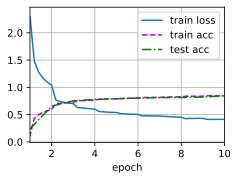

In [10]:
lr,num_epochs,batch_size=1.0,10,128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())